# Clustering MNIST data using openTSNE

### data imports and preprocessing

In [1]:
%matplotlib inline 

import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist
import numpy as np 
from openTSNE import TSNE


import openTSNE
print('openTSNE', openTSNE.__version__)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

2024-12-13 09:41:57.030736: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


openTSNE 1.0.2


In [2]:
# preprocessing MNIST data 
X = np.zeros((x_train.shape[0], 784))
for i in range(x_train.shape[0]):
    X[i] = x_train[i].flatten()
X = pd.DataFrame(X)
Y = pd.DataFrame(y_train)

# shuffle dataset and take random 20% for visualisation with tSNE 
X_sample = X.sample(frac=0.2, random_state=12).reset_index(drop=True)
Y_sample = Y.sample(frac=0.2, random_state=12).reset_index(drop=True)
X_sample.shape

(12000, 784)

In [ ]:
X_sample['label']

### standard tsne

In [19]:
import time

time_start = time.time()
#TODO: look up what n_jobs really does 
#Z1 is just standard t-SNE
standard_tsne = TSNE(n_jobs=-1, random_state=12, verbose=True)
Z1 = standard_tsne.fit(X_sample.to_numpy())

print ('t-SNE done! Total time elapsed: {} seconds'.format(time.time()-time_start))
X_sample['label'] = Y_sample

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=-1, random_state=12, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 29.26 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.86 seconds
===> Running optimization with exaggeration=12.00, lr=1000.00 for 250 iterations...
Iteration   50, KL divergence 4.7945, 50 iterations in 5.2819 sec
Iteration  100, KL divergence 4.8753, 50 iterations in 3.4559 sec
Iteration  150, KL divergence 4.8743, 50 iterations in 4.3128 sec
Iteration  200, KL divergence 4.8740, 50 iterations in 3.6551 sec
Iteration  250, KL divergence 4.8740, 50 iterations in 3.7712 sec
   --> Time elapsed: 20.48 seconds
===> Running optimization with exaggeratio

In [21]:
Z1.kl_divergence

1.9281922673833982

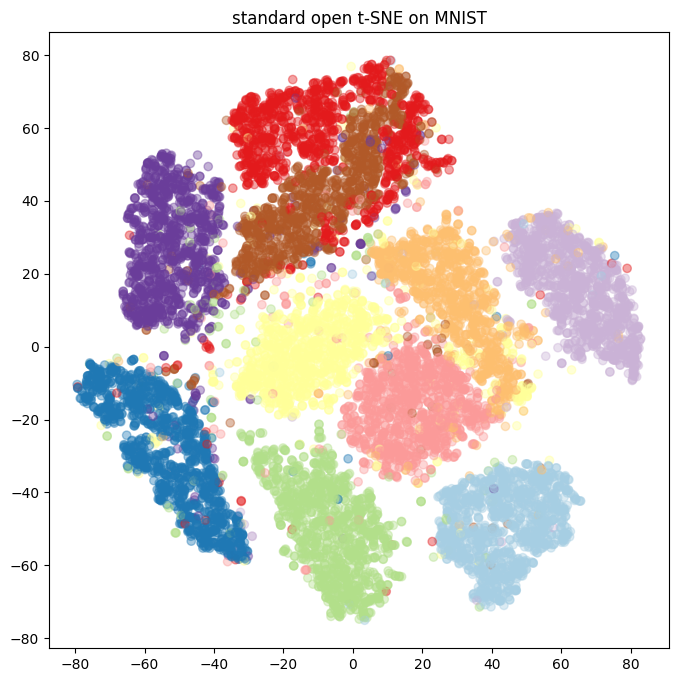

In [20]:
# Create matplotlib visualisation 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, title='standard open t-SNE on MNIST')
# Create the scatter
ax.scatter(
    x=Z1[:,0], 
    y=Z1[:,1], 
    c=X_sample['label'], 
    cmap=plt.colormaps.get_cmap('Paired'), 
    alpha=0.4)
plt.show()

## KL-Divergence plots using advanced features

In [3]:
from openTSNE import callbacks
# Define a custom callback to record KL divergence
class KLTracker(callbacks.Callback):
    def __init__(self, record_every=10):
        self.kl_divergences = []
        self.record_every = record_every

    def __call__(self, iteration, error, embedding):
        # Record KL divergence at the specified interval
        if iteration % self.record_every == 0:
            self.kl_divergences.append((iteration, error))
        return False 

In [31]:
# step 1: define affinities 
affinites = openTSNE.affinity.PerplexityBasedNN(
    X_sample.to_numpy(),
    n_jobs=-1,
    random_state=12,
    verbose=True
    )

===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 36.18 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.60 seconds


In [32]:
# step 2: define initial embedding 
init = openTSNE.initialization.pca(X_sample.to_numpy(), random_state=12)

In [59]:
# step 3: construct TSNEEmbedding object 
from openTSNE import TSNEEmbedding
embedding = TSNEEmbedding(
    init, 
    affinites, 
    verbose=True
)

In [60]:
# step 4: early exaggeration 
kl_tracker_EE = KLTracker(record_every=10)

EE_embedding = embedding.optimize(n_iter=250, exaggeration=12, callbacks= kl_tracker_EE, callbacks_every_iters=10, verbose=True)

===> Running optimization with exaggeration=12.00, lr=1000.00 for 250 iterations...
Iteration   50, KL divergence 4.7995, 50 iterations in 4.1531 sec
Iteration  100, KL divergence 4.8782, 50 iterations in 3.0904 sec
Iteration  150, KL divergence 4.8772, 50 iterations in 2.5570 sec
Iteration  200, KL divergence 4.8769, 50 iterations in 2.6854 sec
Iteration  250, KL divergence 4.8769, 50 iterations in 2.5760 sec
   --> Time elapsed: 15.06 seconds


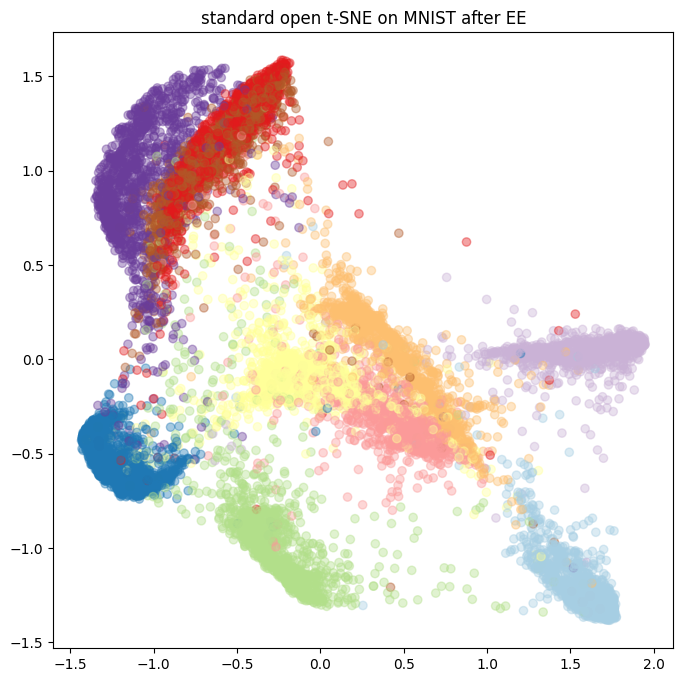

In [61]:
# visualize embedding after early exaggeration 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, title='standard open t-SNE on MNIST after EE')
# Create the scatter
ax.scatter(
    x=EE_embedding[:,0], 
    y=EE_embedding[:,1], 
    c=X_sample['label'], 
    cmap=plt.colormaps.get_cmap('Paired'), 
    alpha=0.4)
plt.show()

In [47]:
# step 5: embedding phase of t-SNE 
kl_tracker_embed = KLTracker(record_every=10)

final_embedding = EE_embedding.optimize(n_iter=500, callbacks=kl_tracker_embed, callbacks_every_iters=10, verbose=True)

===> Running optimization with exaggeration=1.00, lr=12000.00 for 500 iterations...
Iteration   50, KL divergence 2.3670, 50 iterations in 4.5553 sec
Iteration  100, KL divergence 2.1836, 50 iterations in 9.7846 sec
Iteration  150, KL divergence 2.0991, 50 iterations in 12.7596 sec
Iteration  200, KL divergence 2.0496, 50 iterations in 17.4710 sec
Iteration  250, KL divergence 2.0161, 50 iterations in 18.5564 sec
Iteration  300, KL divergence 1.9938, 50 iterations in 15.6673 sec
Iteration  350, KL divergence 1.9723, 50 iterations in 15.9718 sec
Iteration  400, KL divergence 1.9552, 50 iterations in 17.9211 sec
Iteration  450, KL divergence 1.9419, 50 iterations in 19.2752 sec
Iteration  500, KL divergence 1.9307, 50 iterations in 29.1447 sec
   --> Time elapsed: 161.11 seconds


In [49]:
#print(kl_tracker_embed.kl_divergences)
adjusted_divergences = [(iterations + 250, errors) for (iterations, errors) in kl_tracker_embed.kl_divergences]
iterations, errors = zip(*(kl_tracker_EE.kl_divergences + adjusted_divergences))
iterations

(10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 300,
 310,
 320,
 330,
 340,
 350,
 360,
 370,
 380,
 390,
 400,
 410,
 420,
 430,
 440,
 450,
 460,
 470,
 480,
 490,
 500,
 510,
 520,
 530,
 540,
 550,
 560,
 570,
 580,
 590,
 600,
 610,
 620,
 630,
 640,
 650,
 660,
 670,
 680,
 690,
 700,
 710,
 720,
 730,
 740,
 750)

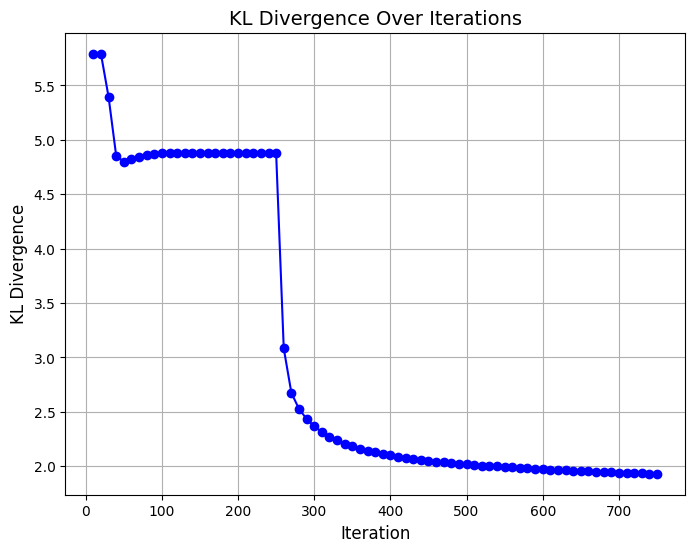

In [51]:
# Plot KL Divergences 
plt.figure(figsize=(8, 6))
plt.plot(iterations, errors, marker='o', linestyle='-', color='b')
plt.title("KL Divergence Over Iterations", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("KL Divergence", fontsize=12)
plt.grid(True)
plt.show()

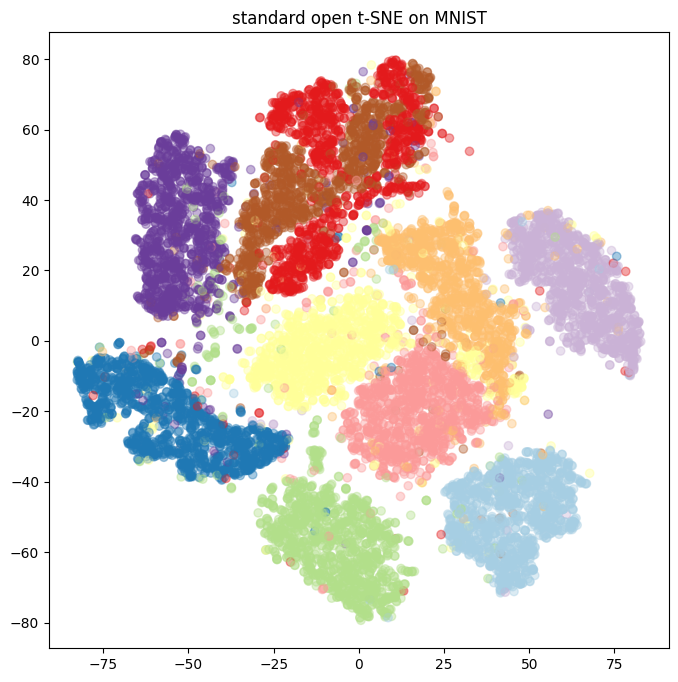

In [52]:
# plot embedding 
# Create matplotlib visualisation 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, title='standard open t-SNE on MNIST')
# Create the scatter
ax.scatter(
    x=final_embedding[:,0], 
    y=final_embedding[:,1], 
    c=X_sample['label'], 
    cmap=plt.colormaps.get_cmap('Paired'), 
    alpha=0.4)
plt.show()

## trying parameters suggested in "Clustering with t-SNE, provably" paper - with KL Divergence plot

In [56]:
# exaggeration = 0.1n, learning rate=1 
n = X_sample.shape[0]

alt_embedding = TSNEEmbedding(
    init, 
    affinites, 
    learning_rate=1, 
    verbose=True
)

kl_tracker_EE = KLTracker(record_every=10)
EE_embedding = alt_embedding.optimize(n_iter=250, exaggeration=0.1*n, callbacks= kl_tracker_EE, callbacks_every_iters=10, verbose=True)

kl_tracker_embed = KLTracker(record_every=10)
final_embedding = EE_embedding.optimize(n_iter=500, callbacks=kl_tracker_embed, callbacks_every_iters=10, verbose=True)

===> Running optimization with exaggeration=1200.00, lr=1.00 for 250 iterations...
Iteration   50, KL divergence 5.7921, 50 iterations in 3.1344 sec
Iteration  100, KL divergence 5.7921, 50 iterations in 2.5662 sec
Iteration  150, KL divergence 5.7921, 50 iterations in 2.8735 sec
Iteration  200, KL divergence 5.7921, 50 iterations in 2.7836 sec
Iteration  250, KL divergence 5.7921, 50 iterations in 2.8638 sec
   --> Time elapsed: 14.22 seconds
===> Running optimization with exaggeration=1.00, lr=1.00 for 500 iterations...
Iteration   50, KL divergence 5.7921, 50 iterations in 2.4836 sec
Iteration  100, KL divergence 5.7921, 50 iterations in 2.9951 sec
Iteration  150, KL divergence 5.7921, 50 iterations in 2.5822 sec
Iteration  200, KL divergence 5.7921, 50 iterations in 2.7069 sec
Iteration  250, KL divergence 5.7921, 50 iterations in 2.6839 sec
Iteration  300, KL divergence 5.7921, 50 iterations in 3.3440 sec
Iteration  350, KL divergence 5.7921, 50 iterations in 2.7423 sec
Iteration 

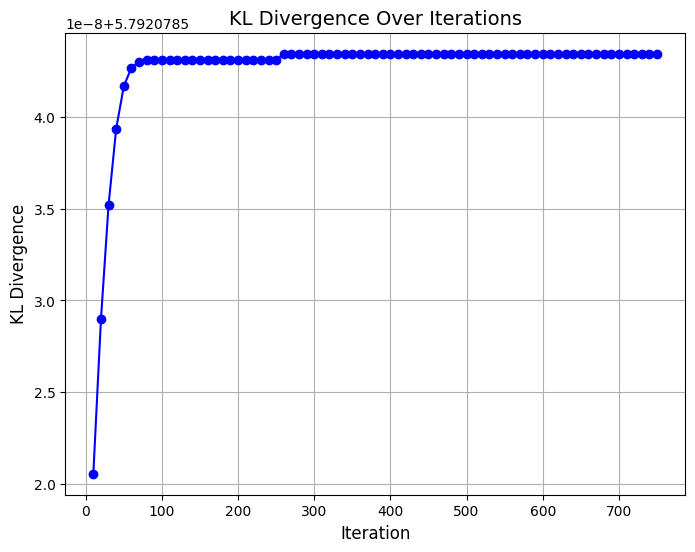

In [57]:
#print(kl_tracker_embed.kl_divergences)
adjusted_divergences = [(iterations + 250, errors) for (iterations, errors) in kl_tracker_embed.kl_divergences]
iterations, errors = zip(*(kl_tracker_EE.kl_divergences + adjusted_divergences))

# Plot KL Divergences 
plt.figure(figsize=(8, 6))
plt.plot(iterations, errors, marker='o', linestyle='-', color='b')
plt.title("KL Divergence Over Iterations", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("KL Divergence", fontsize=12)
plt.grid(True)
plt.show()

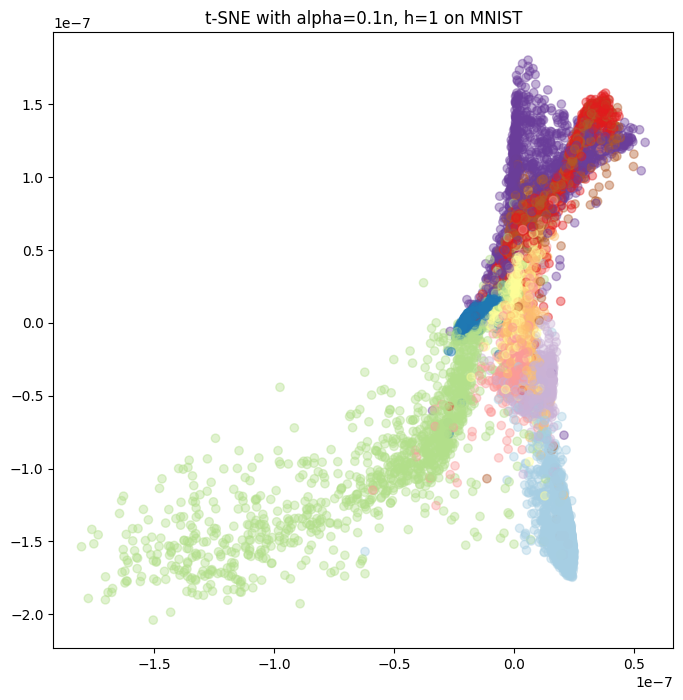

In [62]:
# Create matplotlib visualisation 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, title='t-SNE with alpha=0.1n, h=1 on MNIST')
# Create the scatter
ax.scatter(
    x=final_embedding[:,0], 
    y=final_embedding[:,1], 
    c=X_sample['label'], 
    cmap=plt.colormaps.get_cmap('Paired'), 
    alpha=0.4)
plt.show()

### experimenting with different parameters

In [5]:
import time

time_start = time.time()
#TODO: look up what n_jobs really does 
#Z1 is just standard t-SNE
tsne_without_init = TSNE(initialization="random", n_jobs=-1, random_state=12, verbose=True)
Z1 = tsne_without_init.fit(X_sample.to_numpy())

print ('t-SNE done! Total time elapsed: {} seconds'.format(time.time()-time_start))
X_sample['label'] = Y_sample

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, initialization='random', n_jobs=-1, random_state=12,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 22.35 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.80 seconds
===> Running optimization with exaggeration=12.00, lr=1000.00 for 250 iterations...
Iteration   50, KL divergence 5.7310, 50 iterations in 2.3674 sec
Iteration  100, KL divergence 4.8389, 50 iterations in 2.5010 sec
Iteration  150, KL divergence 4.8746, 50 iterations in 2.3984 sec
Iteration  200, KL divergence 4.8739, 50 iterations in 2.5982 sec
Iteration  250, KL divergence 4.8739, 50 iterations in 2.2702 sec
   --> Time elapsed: 12.14 seconds
===> Running optimization with exaggeration=1.00, lr=12000.00 for 500 iterations...
Iterati

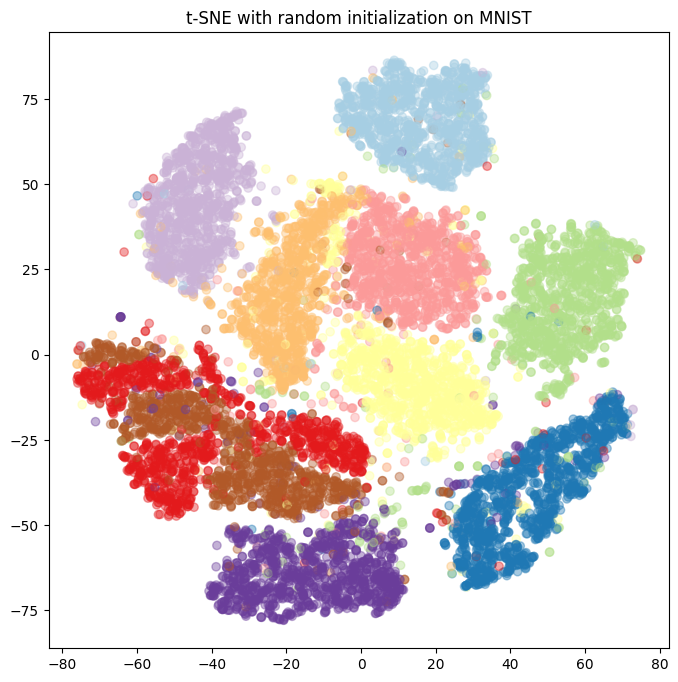

In [7]:
# Create matplotlib visualisation 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, title='t-SNE with random initialization on MNIST')
# Create the scatter
ax.scatter(
    x=Z1[:,0], 
    y=Z1[:,1], 
    c=X_sample['label'], 
    cmap=plt.colormaps.get_cmap('Paired'), 
    alpha=0.4)
plt.show()